Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [11]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [41]:
sel = np.floor(np.random.rand(2 * batch_size) * len(train_dataset)).astype(int)
sel

array([ 66007,  60420,  26951, ..., 154356, 102032, 195909])

In [51]:
hidden_layer_size=1024
batch_size = 2000

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_lambda = tf.placeholder(tf.float32)
    tf_full_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    W1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    b1 = tf.Variable(tf.zeros([hidden_layer_size]))
    W2 = tf.Variable(
        tf.truncated_normal([hidden_layer_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    a1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    logits = tf.matmul(a1, W2) + b2
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    loss += tf_lambda * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    mini_train_prediction = tf.nn.softmax(logits)
    train_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_full_train_dataset, W1) + b1), W2) + b2)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1), W2) + b2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1), W2) + b2)

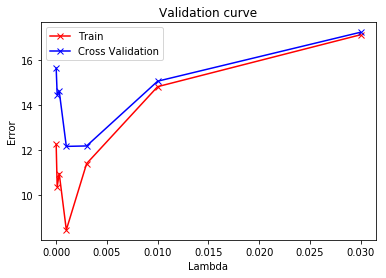

In [87]:
lambdas = [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]
num_steps = 3001

error_trains = np.zeros(len(lambdas))
error_vals = np.zeros(len(lambdas))

for i, lambda_t in enumerate(lambdas) :

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        #print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
                
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lambda : lambda_t}
            _, l, predictions = session.run([optimizer, loss, mini_train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        #print("Train accuracy: %.1f%%" % accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset_sel}), train_labels_sel))
        #print("Cross validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        error_trains[i] = 100-accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset_sel}), train_labels_sel)
        error_vals[i] = 100-accuracy(valid_prediction.eval(), valid_labels)
    
plt.figure()
plt.plot(lambdas, error_trains, 'rx-', label='Train', )
plt.plot(lambdas, error_vals, 'bx-', label='Cross Validation')
plt.legend()
plt.title('Validation curve') 
plt.xlabel('Lambda')
plt.ylabel('Error')

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Training neural network with 2000 training sample
Test accuracy: 86.1%
Training neural network with 10000 training sample
Test accuracy: 88.0%
Training neural network with 20000 training sample
Test accuracy: 89.7%
Training neural network with 100000 training sample
Test accuracy: 93.0%
Training neural network with 200000 training sample
Test accuracy: 93.6%


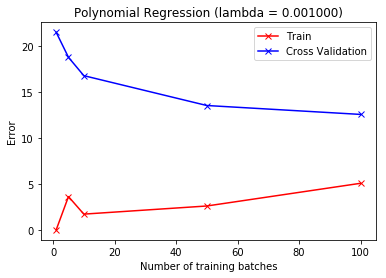

In [93]:
lambda_t = 0.001
num_batches = [1, 5, 10, 50, 100]

error_trains = np.zeros(len(num_batches))
error_vals = np.zeros(len(num_batches))

num_steps = 3001

for j, num_batch in enumerate(num_batches):
    
    #Randomly select training set
    print("Training neural network with %d training sample" % (num_batch * batch_size))
    sel = np.floor(np.random.rand(num_batch * batch_size) * len(train_dataset)).astype(int)

    train_dataset_sel = train_dataset[sel, :]
    train_labels_sel = train_labels[sel, :]

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        #print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            if(train_dataset_sel.shape[0] - batch_size != 0):
                offset = (step * batch_size) % (train_dataset_sel.shape[0] - batch_size)
            else:
                offset = 0
            # Generate a minibatch.
            batch_data = train_dataset_sel[offset:(offset + batch_size), :]
            batch_labels = train_labels_sel[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lambda : lambda_t}
            _, l, predictions = session.run([optimizer, loss, mini_train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        #print("Train accuracy: %.1f%%" % accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset_sel}), train_labels_sel))
        #print("Cross validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        error_trains[j] = 100-accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset_sel}), train_labels_sel)
        error_vals[j] = 100-accuracy(valid_prediction.eval(), valid_labels)

plt.figure()
plt.plot(num_batches, error_trains, 'rx-', label='Train', )
plt.plot(num_batches, error_vals, 'bx-', label='Cross Validation')
plt.legend()
plt.title('Polynomial Regression (lambda = %f)' % lambda_t) 
plt.xlabel('Number of training batches')
plt.ylabel('Error')

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [94]:
hidden_layer_size=1024
batch_size = 2000
dropout = 0.5

graph_dropout = tf.Graph()
with graph_dropout.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_lambda = tf.placeholder(tf.float32)
    tf_full_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    W1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    b1 = tf.Variable(tf.zeros([hidden_layer_size]))
    W2 = tf.Variable(
        tf.truncated_normal([hidden_layer_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    a1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    logits = tf.matmul(tf.nn.dropout(a1, dropout), W2) + b2
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    loss += tf_lambda * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    mini_train_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1) * dropout, W2) + b2)
    train_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_full_train_dataset, W1) + b1) * dropout, W2) + b2)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1), W2) * dropout + b2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1), W2) * dropout + b2)

Training neural network with 2000 training sample
Test accuracy: 88.8%
Training neural network with 10000 training sample
Test accuracy: 90.7%
Training neural network with 20000 training sample
Test accuracy: 92.0%
Training neural network with 100000 training sample
Test accuracy: 92.6%
Training neural network with 200000 training sample
Test accuracy: 92.5%


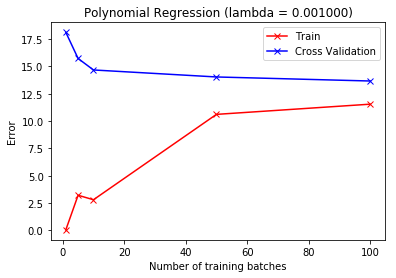

In [95]:
lambda_t = 0.001
num_batches = [1, 5, 10, 50, 100]

error_trains = np.zeros(len(num_batches))
error_vals = np.zeros(len(num_batches))

num_steps = 3001

for j, num_batch in enumerate(num_batches):
    
    #Randomly select training set
    print("Training neural network with %d training sample" % (num_batch * batch_size))
    sel = np.floor(np.random.rand(num_batch * batch_size) * len(train_dataset)).astype(int)

    train_dataset_sel = train_dataset[sel, :]
    train_labels_sel = train_labels[sel, :]

    with tf.Session(graph=graph_dropout) as session:
        tf.global_variables_initializer().run()
        #print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            if(train_dataset_sel.shape[0] - batch_size != 0):
                offset = (step * batch_size) % (train_dataset_sel.shape[0] - batch_size)
            else:
                offset = 0
            # Generate a minibatch.
            batch_data = train_dataset_sel[offset:(offset + batch_size), :]
            batch_labels = train_labels_sel[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lambda : lambda_t}
            _, l, predictions = session.run([optimizer, loss, mini_train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        #print("Train accuracy: %.1f%%" % accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset_sel}), train_labels_sel))
        #print("Cross validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        error_trains[j] = 100-accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset_sel}), train_labels_sel)
        error_vals[j] = 100-accuracy(valid_prediction.eval(), valid_labels)

plt.figure()
plt.plot(num_batches, error_trains, 'rx-', label='Train', )
plt.plot(num_batches, error_vals, 'bx-', label='Cross Validation')
plt.legend()
plt.title('Polynomial Regression (lambda = %f)' % lambda_t) 
plt.xlabel('Number of training batches')
plt.ylabel('Error')

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [252]:
# create a network of 4 layers, 1024-300-50 hidden neurons respectively

hidden_layer_size_1 =1024
hidden_layer_size_2 =300
hidden_layer_size_3 =50
batch_size = 2000
dropout = 0.5
lambda_t = 0.0001

graph_final = tf.Graph()
with graph_final.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_full_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_lambda = tf.placeholder(tf.float32)

    # Variables.
    W1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_layer_size_1], stddev=0.1))
    b1 = tf.Variable(tf.zeros([hidden_layer_size_1]))
    W2 = tf.Variable(
        tf.truncated_normal([hidden_layer_size_1, hidden_layer_size_2], stddev=0.1))
    b2 = tf.Variable(tf.zeros([hidden_layer_size_2]))
    W3 = tf.Variable(
        tf.truncated_normal([hidden_layer_size_2, hidden_layer_size_3], stddev=0.1))
    b3 = tf.Variable(tf.zeros([hidden_layer_size_3]))
    W4 = tf.Variable(
        tf.truncated_normal([hidden_layer_size_3, num_labels], stddev=0.1))
    b4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    a1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    a2 = tf.nn.relu(tf.matmul(tf.nn.dropout(a1, dropout), W2) + b2)
    a3 = tf.nn.relu(tf.matmul(tf.nn.dropout(a2, dropout), W3) + b3)
    logits = tf.matmul(tf.nn.dropout(a3, dropout), W4) + b4
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    loss += tf_lambda * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4))

    # Optimizer.
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(0.5, global_step, 80000, 0.9)
    gradOptimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    gvs = gradOptimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
    optimizer = gradOptimizer.apply_gradients(capped_gvs, global_step=global_step)

    # Predictions for the training, validation, and test data.
    mini_train_prediction = tf.nn.softmax(logits)
    
    train_a1 = tf.nn.relu(tf.matmul(tf_full_train_dataset, W1) + b1)
    train_a2 = tf.nn.relu(tf.matmul(train_a1, W2) + b2)
    train_a3 = tf.nn.relu(tf.matmul(train_a2, W3) + b3)
    train_prediction = tf.nn.softmax(tf.matmul(train_a3, W4) + b4)
    
    valid_a1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_a2 = tf.nn.relu(tf.matmul(valid_a1, W2) + b2)
    valid_a3 = tf.nn.relu(tf.matmul(valid_a2, W3) + b3)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_a3, W4) + b4)
    
    test_a1 = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_a2 = tf.nn.relu(tf.matmul(test_a1, W2) + b2)
    test_a3 = tf.nn.relu(tf.matmul(test_a2, W3) + b3)
    test_prediction = tf.nn.softmax(tf.matmul(test_a3, W4) + b4)

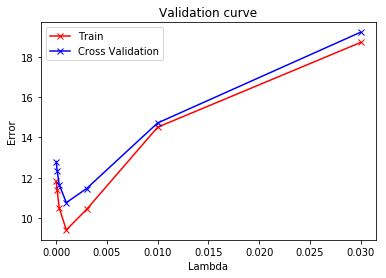

In [254]:
lambdas = [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]
num_steps = 3001

error_trains = np.zeros(len(lambdas))
error_vals = np.zeros(len(lambdas))

for i, lambda_t in enumerate(lambdas) :

    with tf.Session(graph=graph_final) as session:
        tf.global_variables_initializer().run()
        #print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
                
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lambda : lambda_t}
            _, l, predictions = session.run([optimizer, loss, mini_train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            #    print("Minibatch loss at step %d: %f" % (step, l))
            #    print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #    print("Validation accuracy: %.1f%%" % accuracy(
            #        valid_prediction.eval(), valid_labels))
        #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        error_trains[i] = 100-accuracy(train_prediction.eval({tf_full_train_dataset: train_dataset_sel}), train_labels_sel)
        error_vals[i] = 100-accuracy(valid_prediction.eval(), valid_labels)
    
plt.figure()
plt.plot(lambdas, error_trains, 'rx-', label='Train', )
plt.plot(lambdas, error_vals, 'bx-', label='Cross Validation')
plt.legend()
plt.title('Validation curve') 
plt.xlabel('Lambda')
plt.ylabel('Error')

In [255]:
num_steps = 10001
lambda_t = 0.001

with tf.Session(graph=graph_final) as session:
    tf.global_variables_initializer().run()
    #print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lambda : lambda_t}
        _, l, predictions = session.run([optimizer, loss, mini_train_prediction], feed_dict=feed_dict)
        if (step % 2000 == 0):* 
            valid_predictions = valid_prediction.eval()
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_predictions , valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 14.845741
Minibatch accuracy: 10.7%
Validation accuracy: 11.9%
Minibatch loss at step 2000: 1.150446
Minibatch accuracy: 85.5%
Validation accuracy: 88.1%
Minibatch loss at step 4000: 0.601956
Minibatch accuracy: 87.5%
Validation accuracy: 89.6%
Minibatch loss at step 6000: 0.533449
Minibatch accuracy: 89.0%
Validation accuracy: 90.1%
Minibatch loss at step 8000: 0.484396
Minibatch accuracy: 89.8%
Validation accuracy: 90.0%
Minibatch loss at step 10000: 0.476706
Minibatch accuracy: 90.3%
Validation accuracy: 90.4%
Test accuracy: 95.9%


### Implementation notes:

* use stddev=0.1, allow you to use higher learning rate. tf.Variable(tf.truncated_normal([hidden_layer_size_2, hidden_layer_size_3], stddev=0.1))

* I haven't try to use decay function in learning rate. I set the decay step to 80,000, which more or less a constant if the nn is trained using 10,000 step.

* I cramp the gradient between 10 to -10. but the effect is unclear.